# Objective

Develop a minimum viable model that can predict which direction a stock will go

## The Data

### Input Variables

1. Sentiment
    - Bullish, Bearish, Total_compound
2. Financial
3. Technical

### Target Variable

1. 1-day price direction
2. 2-day price direction

# Import Libraries

In [46]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

import requests
import json
import datetime

# Cleaning the Data

In [47]:
# Import data and convert date column to datetime datatype
data = pd.read_csv('historic_sentiment_analysis.csv')
data['date'] = pd.to_datetime(data['date'])

In [48]:
data.head()

,stock,Bearish,Neutral,Bullish,Total_Compound,date,assetType,assetMainType,cusip,symbol,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,CLOV,0.036,0.749,0.215,0.328,2021-06-03,EQUITY,EQUITY,18914F103,CLOV,...,0.0,0.0,0.0,0.0,0.00,,0.00000,13468700.0,13468699.0,4.771102e+08
1,CLNE,0.017,0.789,0.194,0.398,2021-06-03,EQUITY,EQUITY,184499101,CLNE,...,0.0,0.0,0.0,0.0,0.00,,1.84330,5293610.0,5293614.0,1.434198e+08
2,TLRY,0.117,0.786,0.097,0.018,2021-06-03,EQUITY,EQUITY,88688T100,TLRY,...,0.0,0.0,0.0,0.0,0.00,,0.00000,28527700.0,28527703.0,4.933556e+08
3,AAPL,0.080,0.720,0.200,0.174,2021-06-03,EQUITY,EQUITY,37833100,AAPL,...,0.0,0.0,0.0,0.0,0.22,00:00.0,1.20359,73329560.0,73329559.0,2.016039e+09
4,WKHS,0.119,0.764,0.117,-0.019,2021-06-03,EQUITY,EQUITY,98138J206,WKHS,...,0.0,0.0,0.0,0.0,0.00,,2.63773,11332520.0,11332520.0,2.795409e+08


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               365 non-null    object        
 1   Bearish                             365 non-null    float64       
 2   Neutral                             365 non-null    float64       
 3   Bullish                             365 non-null    float64       
 4   Total_Compound                      365 non-null    float64       
 5   date                                365 non-null    datetime64[ns]
 6   assetType                           365 non-null    object        
 7   assetMainType                       365 non-null    object        
 8   cusip                               365 non-null    object        
 9   symbol                              365 non-null    object        
 10  description              

## Unnecessary Columns

Let's dig into dividend data. 

In [50]:
data[['divYield', 'divAmount', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate']].head(10)

,divYield,divAmount,divDate,dividendYield,dividendAmount,dividendDate
0,0.00,0.00,NaN,0.00,0.00,
1,0.00,0.00,NaN,0.00,0.00,
2,0.00,0.00,NaN,0.00,0.00,
3,0.70,0.88,00:00.0,0.70,0.88,00:00.0
4,0.00,0.00,NaN,0.00,0.00,
5,0.00,0.00,NaN,0.00,0.00,
6,0.00,0.00,NaN,0.00,0.00,
7,0.00,0.00,NaN,0.00,0.00,
8,0.71,0.88,00:00.0,0.71,0.88,00:00.0
9,0.09,0.64,00:00.0,0.09,0.64,00:00.0


Most of the values are null/zero values because most stocks don't provide dividends.

Also, there are duplicate columns (ex: divAmount & dividendAmount).

For simplicity, let's consolidate them columns into one as follows:
1. Remove the dividendDate/divDate columns. Keeping this would be redundant
2. Remove divYield column, it contains the same information as divAmount
3. The information from the 6 columns is contained in divAmount:
    - Whether the stock pays a dividend or not
    - How much is paid per stock owned

In [51]:
data.drop(['divYield', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate', 'dividendPayDate'], axis=1, inplace=True)

Several columns are either identifiers, duplicates or empty, we don't need them for this project

In [52]:
data.drop(['cusip',
           'assetType',
           'description',
           'assetMainType',
           'symbol',
           'securityStatus',
           'symbol.1',
           'bidTick',
           'exchangeName',
           'peRatio.1'], axis=1, inplace=True)

Categorical columns

In [53]:
data.select_dtypes(include='object')

,stock,bidId,askId,lastId,exchange
0,CLOV,P,P,P,q
1,CLNE,Q,P,P,q
2,TLRY,P,P,P,q
3,AAPL,P,P,D,q
4,WKHS,P,P,D,q
...,...,...,...,...,...
360,MSFT,V,N,D,q
361,SOFI,Z,V,D,q
362,DKNG,Q,K,D,q
363,CLNE,Q,N,D,q


In [54]:
print(data['bidId'].nunique())
print(data['askId'].nunique())
print(data['lastId'].nunique())
print(data['exchange'].nunique())

11
11
10
1


exchange column has only 1 unique value, which would likely not add predictability

In [55]:
data.drop(['exchange'], axis=1, inplace=True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               365 non-null    object        
 1   Bearish                             365 non-null    float64       
 2   Neutral                             365 non-null    float64       
 3   Bullish                             365 non-null    float64       
 4   Total_Compound                      365 non-null    float64       
 5   date                                365 non-null    datetime64[ns]
 6   bidPrice                            365 non-null    float64       
 7   bidSize                             365 non-null    int64         
 8   bidId                               365 non-null    object        
 9   askPrice                            365 non-null    float64       
 10  askSize                   

## Boolean Values

In [57]:
data['bidSize'].dtypes

dtype('int64')

In [58]:
data.select_dtypes(include='boolean')

,marginable,shortable,delayed,realtimeEntitled
0,True,True,True,False
1,True,True,True,False
2,True,True,True,False
3,True,True,True,False
4,True,True,True,False
...,...,...,...,...
360,True,True,True,False
361,True,True,True,False
362,True,True,True,False
363,True,True,True,False


In [59]:
print(data['marginable'].nunique())
print(data['shortable'].nunique())
print(data['delayed'].nunique())
print(data['realtimeEntitled'].nunique())

1
1
1
1


None of these columns provide any valuable information

In [60]:
data['bidSize'].dtypes

dtype('int64')

In [61]:
data.drop(['marginable', 'shortable', 'delayed', 'realtimeEntitled'], axis=1, inplace=True, )

In [62]:
data['bidSize'].dtypes

dtype('int64')

In [63]:
#data = data.transpose(copy=True).drop_duplicates().transpose(copy=True)

## Null Values

In [64]:
data.isna().sum().sum()

0

We're good to go

## Columns with minimal unique values

Variables with a single value in the column will not likely provide any predictability

In [65]:
list(data.columns)

for column in list(data.columns):
    if data[column].nunique() <= 1:
        data.drop(column, axis=1, inplace=True)

# Bring in price data with TDAmeritrade API

In [66]:
# Date range of our dataset
print(data['date'].min().date())
print(data['date'].max().date())
print(data['date'].max().date() - data['date'].min().date())

2021-06-03
2021-07-19
46 days, 0:00:00


Based on the date range of our dataset, our API call should generate about 2 months of price history

In [86]:
### Note: The API does not produce data on the weekends

api_key = "***REMOVED***"
price_data = pd.DataFrame()

for stock in list(data['stock'].unique()):
    symbol = stock
    url = f'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory?apikey={api_key}&periodType=month&period=2&frequencyType=daily&frequency=1'
    raw_data = requests.get(url).json()
    # raw_data = requests.get(url)
    # print(raw_data.status_code)
    # print(raw_data)
    raw_data = pd.json_normalize(raw_data, record_path=['candles'])
    raw_data.rename(columns = {'datetime': 'date'}, inplace=True)
    raw_data['date'] = pd.to_datetime(raw_data['date'], unit='ms')
    raw_data['date'] = [raw_data['date'][i].date() for i in range(len(raw_data['date']))]
    raw_data['stock'] = [stock for x in range(len(raw_data))]

    # Calc returns
    raw_data['1d-return'] = raw_data['close'].diff(periods=1)
    raw_data['2d-return'] = raw_data['close'].diff(periods=2)
    raw_data['5d-return'] = raw_data['close'].diff(periods=5)

    # Determine direction of return
    raw_data['1d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['1d-return']]
    raw_data['2d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['2d-return']]
    raw_data['5d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['5d-return']]

    # Concat dataframes
    price_data = pd.concat([price_data, raw_data], ignore_index=True)
    price_data = price_data[['date',
                             'stock',
                             'close',
                             '1d-return',
                             '1d-direction',
                             '2d-return',
                             '2d-direction',
                             '5d-return',
                             '5d-direction']]

# First n values in direction columns should be NaN
price_data['1d-direction'][0] = np.nan
price_data['2d-direction'][0: 2] = [np.nan for x in price_data['2d-direction'][0: 2]]
price_data['5d-direction'][0: 5] = [np.nan for x in price_data['5d-direction'][0: 5]]

price_data['1d-return'] = price_data['1d-return'].shift(1)
price_data['1d-direction'] = price_data['1d-direction'].shift(1)

price_data['2d-return'] = price_data['2d-return'].shift(1)
price_data['2d-direction'] = price_data['2d-direction'].shift(1)

price_data['5d-return'] = price_data['5d-return'].shift(1)
price_data['5d-direction'] = price_data['5d-direction'].shift(1)

price_data.dropna(inplace=True)
price_data.reset_index(inplace=True)
price_data.drop('index', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,date,stock,close,1d-return,1d-direction,2d-return,2d-direction,5d-return,5d-direction
0,2021-05-25,CLOV,7.020,-0.010,-1.0,-0.210,-1.0,0.100,1.0
1,2021-05-26,CLOV,7.330,0.100,1.0,0.090,1.0,0.050,1.0
2,2021-05-27,CLOV,7.830,0.310,1.0,0.410,1.0,0.490,1.0
3,2021-05-28,CLOV,7.640,0.500,1.0,0.810,1.0,0.700,1.0
4,2021-06-01,CLOV,7.730,-0.190,-1.0,0.310,1.0,0.710,1.0
...,...,...,...,...,...,...,...,...,...
1362,2021-07-12,MRNA,239.340,0.020,1.0,10.910,1.0,-2.300,-1.0
1363,2021-07-13,MRNA,235.150,6.530,1.0,6.550,1.0,5.040,1.0
1364,2021-07-14,MRNA,246.660,-4.190,-1.0,2.340,1.0,1.810,1.0
1365,2021-07-15,MRNA,259.675,11.510,1.0,7.320,1.0,24.760,1.0


In [87]:
# Filter out dates to match those of the 'data' dataframe
filter_ = (price_data['date'] >= data['date'].min().date()) & (price_data['date'] <= data['date'].max().date())
price_data = price_data[filter_]
price_data.reset_index(inplace=True)
price_data.drop('index', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [88]:
# Instantiate combined dataframe
column_list = list(price_data.columns) + list(data.columns)
combined_df = pd.DataFrame(columns=column_list)

# Iterate through both dataframes to match date and stock and append matching rows into combined_df
for ind in price_data.index:
    for indx in data.index:
        if price_data['date'][ind] == data['date'][indx] and price_data['stock'][ind] == data['stock'][indx]:
            series_list = [
                pd.to_datetime(price_data['date'][ind]),
                price_data['stock'][ind],
                price_data['close'][ind],
                price_data['1d-return'][ind],
                price_data['1d-direction'][ind],
                price_data['2d-return'][ind],
                price_data['2d-direction'][ind],
                price_data['5d-return'][ind],
                price_data['5d-direction'][ind]] + list(data.iloc[indx])
            combined_df = combined_df.append(pd.Series(
                    series_list,
                    index=column_list
                ), ignore_index=True)

# We don't need duplicate 'date' and 'stock' columns anymore
combined_df = combined_df.iloc[:, 2:]
combined_df.sort_values(by='date', ignore_index=True, inplace=True)

Officially ready for modeling

# Minimal Viable Product

## Features and Target Variables

In [89]:
# Convert target to numeric datatype
int_list = ['bidSize', 'askSize', 'lastSize', 'totalVolume', 'regularMarketLastSize']

for int_ in int_list:
    combined_df[int_] = pd.to_numeric(combined_df[int_])

combined_df['1d-direction'] = pd.to_numeric(combined_df['1d-direction'])

In [90]:
X = combined_df.loc[:, 'Bearish':].drop('date', axis=1)
y = combined_df['1d-direction']

## Encode Categorical Variables

In [91]:
from sklearn.preprocessing import OneHotEncoder

categoricals = list(X.select_dtypes('object').columns)
numericals = list(X.select_dtypes(['int64', 'float64']).columns)

def encode_cats(categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=X.index) #keep the same index values
    
    return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [92]:
X = encode_cats(categoricals, numericals)

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [94]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_scaled, y, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_scaled, y, cv = 5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_scaled, y, cv=5)

gbm = xgb.XGBClassifier()
gbm_scores = cross_val_score(gbm, X_scaled, y, cv=5)

print(np.mean(knn_scores))
print(np.mean(lr_scores))
print(np.mean(rf_scores))
print(np.mean(gbm_scores))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.59256038647343
0.6009661835748792
0.5884057971014492
0.5706280193236715


## Confusion Matrix

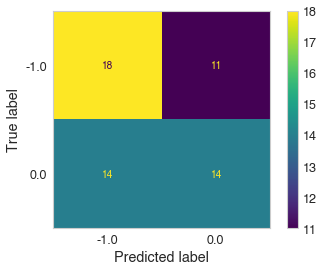

In [105]:
rf.fit(X_scaled, y)

plot_confusion_matrix(rf, X_test_scaled, y_test)
plt.grid(b=None)
plt.show()


In [126]:
# Precicion score
print(f"Precision Score: {precision_score(y_test, rf.predict(X_test_scaled), average='weighted'):.4f}")

Precision Score: 0.5613


In [127]:
# Recall Score
print(f"Precision Score: {recall_score(y_test, rf.predict(X_test_scaled), average='weighted'):.4f}")

Precision Score: 0.5614
